In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotnine
from plotnine import *

import itertools
import difflib
import sys
import os

from tqdm.auto import tqdm
from pprint import pprint

from dfply import *

# ! pip install geemap
# import geemap

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
from Modules.Modules import get_img_df,filter_exclude, stats_GAEZ_Yearbook
# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

### Validata the GAEZ data against Yearbook data

In [9]:
yearbook_xls

['Anhui_crop_livestock_Production.xls',
 'Beijing_crop_livestock_Production.xls',
 'Hebei_crop_livestock_Production.xls',
 'Henan_crop_livestock_Production.xls',
 'Shandong_crop_livestock_Production.xls',
 'Tianjin_crop_livestock_Production.xls']

In [13]:
# import the admin boundary
China_cities = ee.FeatureCollection("users/wangjinzhulala/China_Boundary/1_China_Cities_cn")


# import the yearbook as reference data
yearbook_xls = os.listdir("../Data/06_Yearbook/Agricultural_production")
yearbook_xls = [i for i in yearbook_xls if '.xls' in i]

# remove some incomplete records
remove_recordes = ['Jiangsu']
yearbook_xls = [i for i in yearbook_xls for j in remove_recordes if j not in i]

# read as df
yearbook_dfs = [pd.read_excel(f'../Data/06_Yearbook/Agricultural_production/{i}') for i in yearbook_xls]
yearbook_df = pd.concat([i for i in yearbook_dfs],ignore_index=True)

Validata the Actual crop production

In [14]:
# filter the necessary img
actual_production = get_img_df(img_path = GAEZ_list,
                theme = 'GAEZ_5',
                variable = 'Production',
                time = '2010',
                crop = ['Maize','Wetland_rice','Wheat','Soybean','Potato','Rapeseed'],
                water = ['Total'])

actual_production

,theme,variable,time,crop,water,GEE_path
0,GAEZ_5,Production,2010,Maize,Total,projects/earthengine-legacy/assets/users/wangj...
1,GAEZ_5,Production,2010,Wetland_rice,Total,projects/earthengine-legacy/assets/users/wangj...
2,GAEZ_5,Production,2010,Wheat,Total,projects/earthengine-legacy/assets/users/wangj...
3,GAEZ_5,Production,2010,Soybean,Total,projects/earthengine-legacy/assets/users/wangj...
4,GAEZ_5,Production,2010,Potato,Total,projects/earthengine-legacy/assets/users/wangj...
5,GAEZ_5,Production,2010,Rapeseed,Total,projects/earthengine-legacy/assets/users/wangj...


#### Plot the comparision

In [15]:
# combine GAEZ_zonal stats with yearbook stats
img_df_exp = stats_GAEZ_Yearbook(actual_production,yearbook_df,China_cities,1000)

The GEE_SHP has 64 coresponding records given 75 total yearbook records.


  0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
# # save df to disk
# img_df_exp.to_csv('./result_csv/Validata_GAEZ_yearbook.csv',index=False)

# read the df
img_df_exp = pd.read_csv('./result_csv/Validata_GAEZ_yearbook.csv')
# change the category order, which is used in the plot
img_df_exp['crop'] = img_df_exp['crop'].astype('category')\
                      .cat.reorder_categories(['Maize', 'Wetland_rice', 'Wheat', 'Soybean', 'Potato', 'Rapeseed'])

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


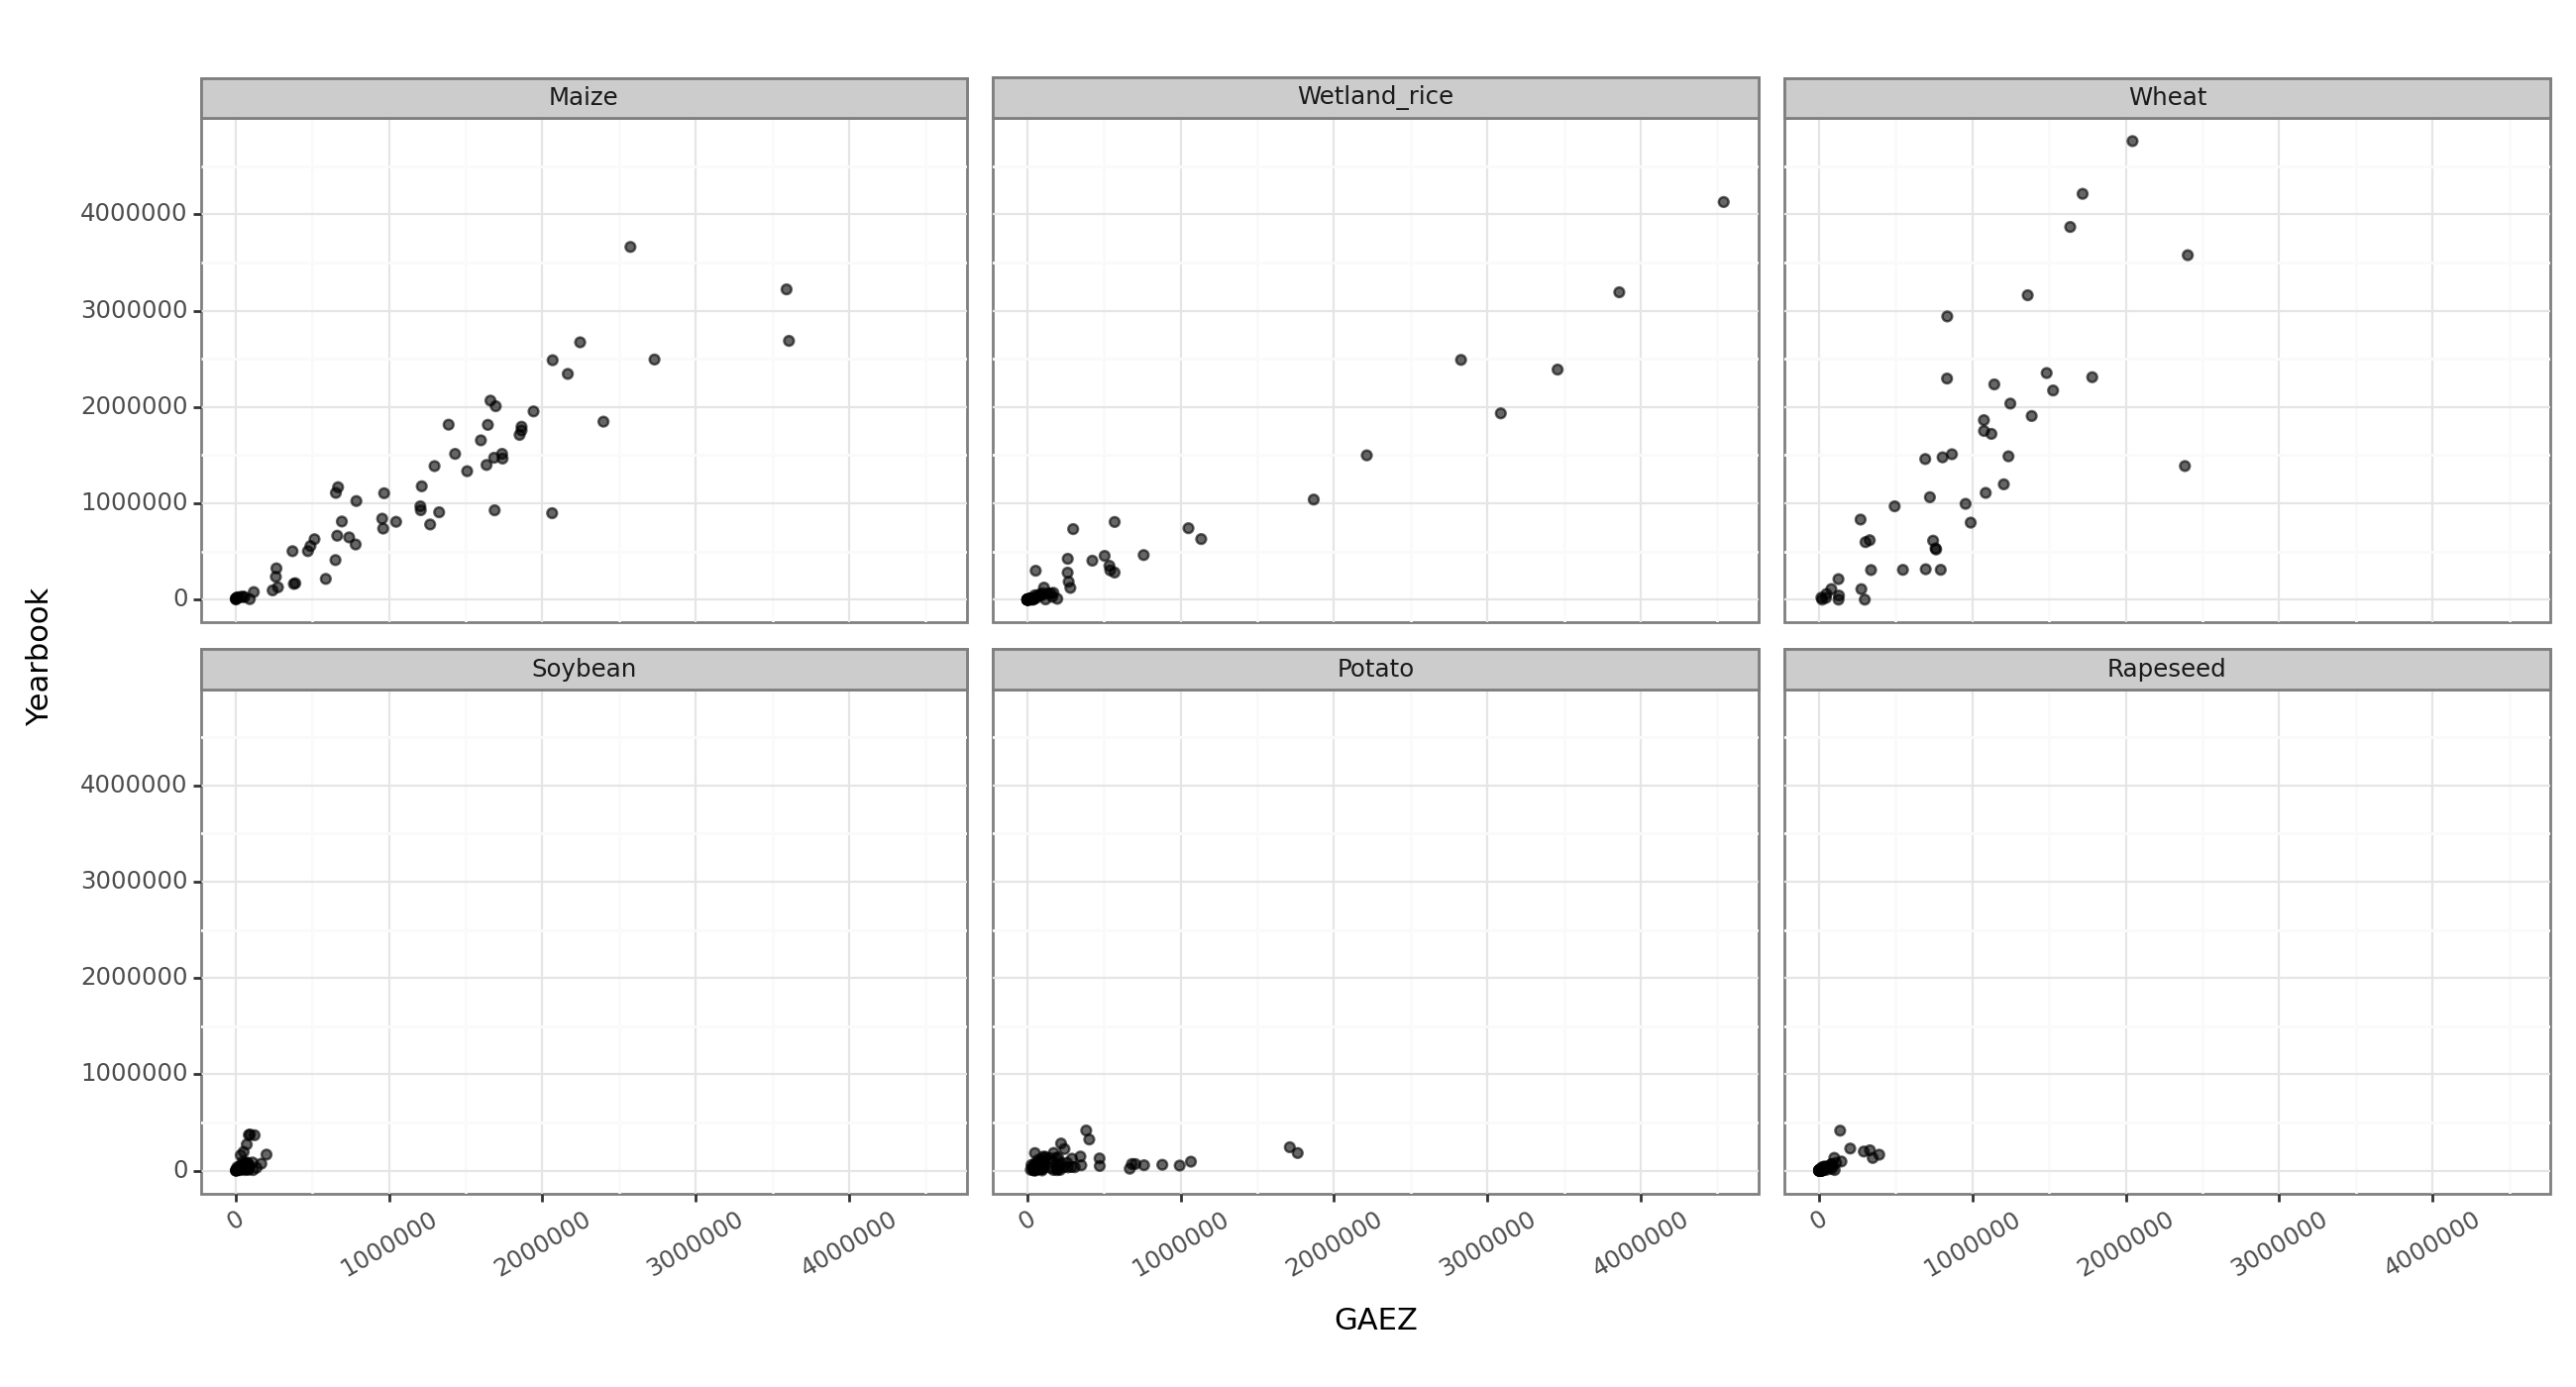

<Figure Size: (1300 x 700)>

In [17]:
plotnine.options.figure_size = (13,7)
plotnine.options.dip = 200

(ggplot(img_df_exp) +
 geom_point(aes('GAEZ','Yearbook'),alpha=0.6) +
 facet_wrap('~crop',nrow=2) +
 theme_bw() +
 theme(axis_text_x=element_text(rotation=30)))